In [18]:
import random
import torch
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [19]:
import torch.nn as nn

def create_hidden_layers(hidden_layer_sizes):
    if not hidden_layer_sizes:
        return []

    hidden_layers = []
    for i in range(1, len(hidden_layer_sizes)):
        hidden_size = hidden_layer_sizes[i]
        hidden_layers.append(nn.Linear(hidden_layer_sizes[i - 1], hidden_size))
    return hidden_layers


class MultiHiddenLayerNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_sizes, activation_function=torch.relu):
        super(MultiHiddenLayerNetwork, self).__init__()

        self.activation_function = activation_function

        if not hidden_layer_sizes:
            self.input_layer = nn.Linear(input_size, output_size)
            hidden_layers = []
        else:
            self.input_layer = nn.Linear(input_size, hidden_layer_sizes[0])
            hidden_layers = create_hidden_layers(hidden_layer_sizes)
            hidden_layers.append(nn.Linear(hidden_layer_sizes[-1], output_size))

        self.hidden_layers = nn.ModuleList(hidden_layers)

    def pass_forward(self, x):

        x = self.input_layer(x)
        for i, hidden_layer in enumerate(self.hidden_layers):
            x = self.activation_function(x)
            x = hidden_layer(x)
        return x


# Network that takes in all the input features and outputs a vector of qualities
class QualitiesPredictor(MultiHiddenLayerNetwork):
    def __init__(self, input_size, num_quality_scores, hidden_layer_sizes):
        super(QualitiesPredictor, self).__init__(input_size, num_quality_scores, hidden_layer_sizes)

    def forward(self, x):
        return super().pass_forward(x)


# Network that takes a quality and the price and predicts the satisfaction
class SatisfactionPredictor(MultiHiddenLayerNetwork):
    def __init__(self, hidden_layer_sizes):
        super(SatisfactionPredictor, self).__init__(2, 1, hidden_layer_sizes)

    def forward(self, q, p):
        # print("Q", q.size())
        # print("P", p.size())
        x = torch.cat((q, p), dim=1)
        # print(x)
        return super().pass_forward(x)


# Takes all the quality scores and predicts a total quality variable
class TotalQualityPredictor(MultiHiddenLayerNetwork):
    def __init__(self, num_quality_scores, hidden_layer_sizes):
        super(TotalQualityPredictor, self).__init__(num_quality_scores, 1, hidden_layer_sizes)

    def forward(self, x):
        return super().pass_forward(x)


class CausalModel(nn.Module):
    def __init__(self, input_size, num_quality_scores,
                 qualities_predictor_hidden_layer_sizes,
                 satisfaction_predictor_hidden_layer_sizes,
                 total_quality_predictor_hidden_layer_sizes):
        super(CausalModel, self).__init__()

        self.num_quality_scores = num_quality_scores

        self.qualities_predictor_net = QualitiesPredictor(input_size, num_quality_scores,
                                                          qualities_predictor_hidden_layer_sizes)

        self.activation_on_quality = nn.Sigmoid()

        self.satisfaction_predictors = [
            SatisfactionPredictor(satisfaction_predictor_hidden_layer_sizes) for _ in range(num_quality_scores)
        ]

        self.total_quality_predictor = TotalQualityPredictor(num_quality_scores,
                                                             total_quality_predictor_hidden_layer_sizes)

        self.total_satisfaction_predictor = SatisfactionPredictor(satisfaction_predictor_hidden_layer_sizes)

    def forward(self, x, p):

        # print("x size: ", x.size())
        qualities = self.qualities_predictor_net(x)
        qualities = self.activation_on_quality(qualities)
        # print("qualities size: ", qualities.size())

        satisfactions_outputs = []
        for i, sat_predictor in enumerate(self.satisfaction_predictors):

            one_quality = torch.unsqueeze(qualities[:, i], 1)

            # print("one quality size: ", one_quality.size())
            # print("price size: ", p.size())
            
            satisfactions_outputs.append(sat_predictor(one_quality, p))

        # print("WHYYYY")
        satisfactions = torch.cat(satisfactions_outputs, dim=1)

        # print("HELLLLLOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO")
        # print("satisfactions size: ", satisfactions.size())

        total_quality = self.total_quality_predictor(qualities)
        total_quality = self.activation_on_quality(total_quality)

        # print("total quality size: ", total_quality.size())
        # print("price size: ", p.size())
        total_satisfaction = self.total_satisfaction_predictor(total_quality, p)

        return satisfactions, total_satisfaction, total_quality

    def loss_function(self, satisfactions, total_satisfaction, satisfactions_targets, total_satisfaction_target):
        # Define custom loss function
        criterion = nn.MSELoss(reduction='sum')  # Use Mean Squared Error as the loss criterion
        # Compute the loss for satisfactions
        loss_satisfactions = criterion(satisfactions, satisfactions_targets)
        # Compute the loss for total_satisfaction
        loss_total_satisfaction = criterion(total_satisfaction, total_satisfaction_target)
        # Add up the losses with appropriate weights (if desired)
        total_loss = loss_satisfactions + loss_total_satisfaction

        return total_loss
    

class CausalModelOnlyTotalQuality(nn.Module):
    def __init__(self, input_size,
                 total_quality_predictor_hidden_layer_sizes,
                 satisfaction_predictor_hidden_layer_sizes):
        super(CausalModelOnlyTotalQuality, self).__init__()

        self.quality_predictor_net = QualitiesPredictor(input_size, 1, total_quality_predictor_hidden_layer_sizes)
        self.activation_on_quality = nn.Sigmoid()
        self.total_satisfaction_predictor = SatisfactionPredictor(satisfaction_predictor_hidden_layer_sizes)

    def forward(self, x, p):
        total_quality = self.activation_on_quality(self.quality_predictor_net(x))
        

        # # Take the log of p and quality ##############
        # total_quality = torch.log(total_quality)
        # p = torch.log(p)
        # ##############################################

        total_satisfaction = self.total_satisfaction_predictor(total_quality, p)

        # ###############################
        # total_satisfaction = torch.exp(total_satisfaction)
        # ##############################

        return total_satisfaction, total_quality

    def loss_function(self, total_satisfaction, total_satisfaction_target):
        criterion = nn.MSELoss(reduction='sum')  # Use Mean Squared Error as the loss criterion
        loss = criterion(total_satisfaction, total_satisfaction_target)
        return loss

In [20]:
import pandas as pd
from torch.utils.data import Dataset

CATEGORIES = ["staff", "facilities", "cleanliness", "comfort", "location"]
# CATEGORIES = []

class CausalDataset(Dataset):
    def __init__(self, df):

        self.X = torch.tensor(df[["stars", "reviews", "rating"] + list(pd.get_dummies(df["city"]).columns)].values).float()
        self.p = torch.tensor(df[["price"]].values).float()
        self.s = torch.tensor(df[CATEGORIES].values).float()
        self.total_s = torch.tensor(df[["rating"]].values).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx, :]
        p = self.p[idx, :]
        s = self.s[idx, :]
        total_s = self.total_s[idx, :]

        return X, p, s, total_s
    

class CausalDatasetOnlyTotalQuality(Dataset):
    def __init__(self, df):

        self.X = torch.tensor(df[["stars", "reviews"] + list(pd.get_dummies(df["city"]).columns)+ CATEGORIES].values).float()
        self.p = torch.tensor(df[["price"]].values).float()
        self.total_s = torch.tensor(df[["rating"]].values).float()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx, :]
        p = self.p[idx, :]
        total_s = self.total_s[idx, :]

        return X, p, total_s

In [21]:
from torch.utils.data import DataLoader

data = pd.read_csv("data.csv")

# Step 2: Split the dataset into train, test, and validation sets
# Define the ratio for train, test, and validation sets
train_ratio = 0.8
test_ratio = 0.1
val_ratio = 0.1

# Get the number of samples in the dataset
num_samples = len(data)

# Calculate the number of samples for train, test, and validation sets
num_train = int(train_ratio * num_samples)
num_test = int(test_ratio * num_samples)
num_val = num_samples - num_train - num_test

# Shuffle the dataset
indices = np.arange(num_samples)
np.random.shuffle(indices)

# Split the dataset into train, test, and validation sets
train_data = data.iloc[indices[:num_train]]
test_data = data.iloc[indices[num_train:num_train + num_test]]
val_data = data.iloc[indices[num_train + num_test:]]

In [22]:
train_set = CausalDataset(train_data)
test_set = CausalDataset(test_data)
val_set = CausalDataset(val_data)

train_loader = DataLoader(train_set, batch_size=128)
test_loader = DataLoader(test_set, batch_size=16)
val_loader = DataLoader(val_set, batch_size=1)

print(data[["reviews"]].head())

NUM_FEATURES = len(data[["stars", "reviews", "rating"] + list(pd.get_dummies(data["city"]).columns)].columns)
NUM_QUALITY_SCORES = len(data[CATEGORIES].columns)

model = CausalModel(input_size=NUM_FEATURES, 
                    num_quality_scores=NUM_QUALITY_SCORES,
                 qualities_predictor_hidden_layer_sizes=[32, 32],
                 satisfaction_predictor_hidden_layer_sizes=[4, 4],
                 total_quality_predictor_hidden_layer_sizes=[8, 8])
model.float()

batch_losses = []
validation_losses = []

    reviews
0 -0.503632
1  0.154328
2 -0.531155
3 -0.192284
4  0.033917


In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 40

for epoch in range(num_epochs):
    model.train()

    for batch_idx, (X, p, target_s, target_total_s) in enumerate(train_loader):
        # print("X size: ", X.size())

        # print("p size: ", p.size())
        # print("s size: ", target_s.size())
        # print("total_s size: ", target_total_s.size())

        batch_size = len(p)
        
        optimizer.zero_grad()
        s, total_s, _total_quality = model(X, p)
        loss = model.loss_function(s, total_s, target_s, target_total_s) / batch_size
        loss.backward()
        optimizer.step()

        # Record batch loss
        batch_loss = loss.item()

        batch_losses.append(batch_loss)
        # Print batch loss
        print('Epoch [{}/{}], Batch [{}/{}], Batch Loss: {:.4f}'
              .format(epoch+1, num_epochs, batch_idx+1, len(train_loader), batch_loss))

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_batch_idx, (val_X, val_p, val_target_s, val_target_total_s) in enumerate(val_loader):
            batch_size = len(val_p)
            val_s, val_total_s, _val_total_quality = model(val_X, val_p)
            val_loss = model.loss_function(val_s, val_total_s, val_target_s, val_target_total_s) / batch_size
            total_val_loss += val_loss.item()

    validation_loss = total_val_loss / len(val_loader)
    validation_losses.append(validation_loss)
    print('Epoch [{}/{}], Validation Loss: {:.4f}'
          .format(epoch+1, num_epochs, validation_loss))

Epoch [1/40], Batch [1/28], Batch Loss: 7.7327
Epoch [1/40], Batch [2/28], Batch Loss: 5.4993
Epoch [1/40], Batch [3/28], Batch Loss: 7.0033
Epoch [1/40], Batch [4/28], Batch Loss: 6.4121
Epoch [1/40], Batch [5/28], Batch Loss: 6.5981
Epoch [1/40], Batch [6/28], Batch Loss: 5.3936
Epoch [1/40], Batch [7/28], Batch Loss: 6.7230
Epoch [1/40], Batch [8/28], Batch Loss: 5.9959
Epoch [1/40], Batch [9/28], Batch Loss: 6.1216
Epoch [1/40], Batch [10/28], Batch Loss: 5.4013
Epoch [1/40], Batch [11/28], Batch Loss: 4.7680
Epoch [1/40], Batch [12/28], Batch Loss: 4.7112
Epoch [1/40], Batch [13/28], Batch Loss: 8.0081
Epoch [1/40], Batch [14/28], Batch Loss: 6.1151
Epoch [1/40], Batch [15/28], Batch Loss: 4.9503
Epoch [1/40], Batch [16/28], Batch Loss: 7.1199
Epoch [1/40], Batch [17/28], Batch Loss: 5.6573
Epoch [1/40], Batch [18/28], Batch Loss: 6.1107
Epoch [1/40], Batch [19/28], Batch Loss: 6.4652
Epoch [1/40], Batch [20/28], Batch Loss: 7.4720
Epoch [1/40], Batch [21/28], Batch Loss: 6.1650
E

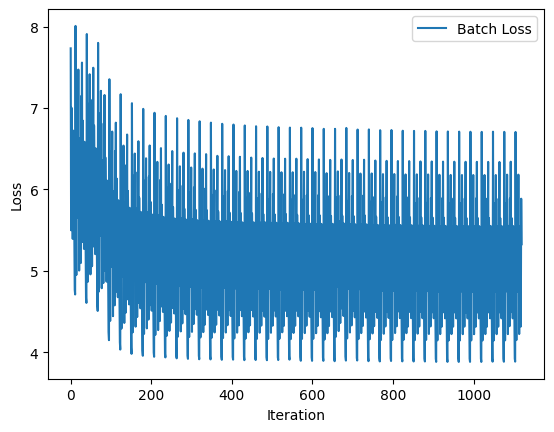

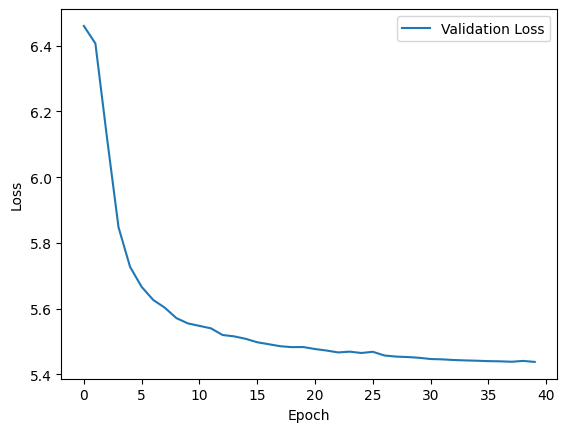

In [24]:
import matplotlib.pyplot as plt

plt.plot(batch_losses, label='Batch Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# Train quality predict for just one quality score

train_set_just_one_quality = CausalDatasetOnlyTotalQuality(train_data)
test_set_just_one_quality = CausalDatasetOnlyTotalQuality(test_data)
val_set_just_one_quality = CausalDatasetOnlyTotalQuality(val_data)

train_loader_just_one_quality = DataLoader(train_set_just_one_quality, batch_size=128)
test_loader_just_one_quality = DataLoader(test_set_just_one_quality, batch_size=1)
val_loader_just_one_quality = DataLoader(val_set_just_one_quality, batch_size=128)

NUM_FEATURES_JUST_ONE_QUALITY = len(["stars", "reviews"] + list(pd.get_dummies(data["city"]).columns) + CATEGORIES)

model_just_one_quality = CausalModelOnlyTotalQuality(input_size=NUM_FEATURES_JUST_ONE_QUALITY, 
                 total_quality_predictor_hidden_layer_sizes=[64, 128, 64],
                 satisfaction_predictor_hidden_layer_sizes=[8, 64, 16])

# model_just_one_quality = CausalModelOnlyTotalQuality(input_size=NUM_FEATURES_JUST_ONE_QUALITY, 
#                  total_quality_predictor_hidden_layer_sizes=[64, 128, 64],
#                  satisfaction_predictor_hidden_layer_sizes=[2, 2])

model_just_one_quality.float()

batch_losses_just_one_quality = []
validation_losses_just_one_quality = []

optimizer_just_one_quality = torch.optim.Adam(model_just_one_quality.parameters(), lr=0.001)

num_epochs_just_one_quality = 50

for epoch in range(num_epochs_just_one_quality):
    model_just_one_quality.train()

    for batch_idx, (X, p, target_total_s) in enumerate(train_loader_just_one_quality):

        batch_size = len(p)
        
        optimizer_just_one_quality.zero_grad()
        total_s, _total_quality = model_just_one_quality(X, p)
        loss = model_just_one_quality.loss_function(total_s, target_total_s) / batch_size
        loss.backward()
        optimizer_just_one_quality.step()

        # Record batch loss
        batch_loss = loss.item()

        batch_losses_just_one_quality.append(batch_loss)
        # Print batch loss
        print('Epoch [{}/{}], Batch [{}/{}], Batch Loss: {:.4f}'
              .format(epoch+1, num_epochs_just_one_quality, batch_idx+1, len(train_loader_just_one_quality), batch_loss))

    model_just_one_quality.eval()
    total_val_loss = 0
    with torch.no_grad():
        for val_batch_idx, (val_X, val_p, val_target_total_s) in enumerate(val_loader_just_one_quality):
            batch_size = len(val_p)
            val_total_s, _val_total_quality = model_just_one_quality(val_X, val_p)
            val_loss = model_just_one_quality.loss_function(val_total_s, val_target_total_s) / batch_size
            total_val_loss += val_loss.item()

    validation_loss = total_val_loss / len(val_loader_just_one_quality)
    validation_losses_just_one_quality.append(validation_loss)
    print('Epoch [{}/{}], Validation Loss: {:.4f}'
          .format(epoch+1, num_epochs_just_one_quality, validation_loss))

Epoch [1/50], Batch [1/28], Batch Loss: 1.4444
Epoch [1/50], Batch [2/28], Batch Loss: 1.0248
Epoch [1/50], Batch [3/28], Batch Loss: 1.4541
Epoch [1/50], Batch [4/28], Batch Loss: 1.1554
Epoch [1/50], Batch [5/28], Batch Loss: 1.0939
Epoch [1/50], Batch [6/28], Batch Loss: 0.8956
Epoch [1/50], Batch [7/28], Batch Loss: 1.0893
Epoch [1/50], Batch [8/28], Batch Loss: 0.8642
Epoch [1/50], Batch [9/28], Batch Loss: 1.0102
Epoch [1/50], Batch [10/28], Batch Loss: 0.7800
Epoch [1/50], Batch [11/28], Batch Loss: 0.7775
Epoch [1/50], Batch [12/28], Batch Loss: 0.7608
Epoch [1/50], Batch [13/28], Batch Loss: 1.2727
Epoch [1/50], Batch [14/28], Batch Loss: 0.9650
Epoch [1/50], Batch [15/28], Batch Loss: 0.7620
Epoch [1/50], Batch [16/28], Batch Loss: 1.2589
Epoch [1/50], Batch [17/28], Batch Loss: 0.8947
Epoch [1/50], Batch [18/28], Batch Loss: 1.0031
Epoch [1/50], Batch [19/28], Batch Loss: 1.0827
Epoch [1/50], Batch [20/28], Batch Loss: 1.3082
Epoch [1/50], Batch [21/28], Batch Loss: 1.0096
E

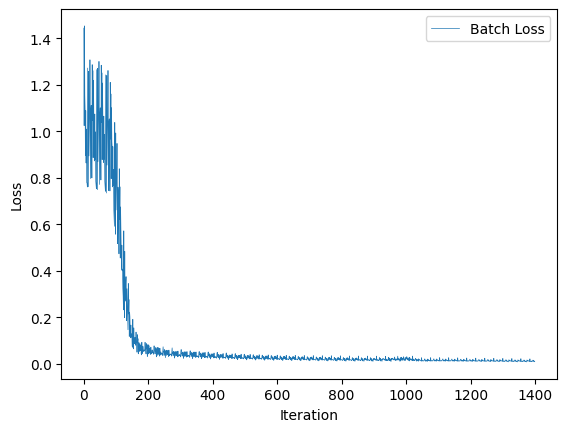

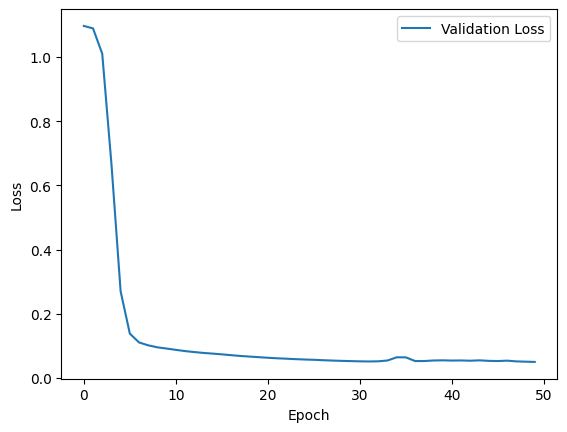

In [26]:
import matplotlib.pyplot as plt

plt.plot(batch_losses_just_one_quality, linewidth=0.5, label='Batch Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(validation_losses_just_one_quality, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
prices = []
qualities = []
true_satisfactions = []
output_satisfactions = []

model_just_one_quality.eval()
total_test_loss = 0
with torch.no_grad():
    for test_batch_idx, (test_X, test_p, test_target_total_s) in enumerate(test_loader_just_one_quality):
        batch_size = len(test_p)
        test_total_s, test_total_quality = model_just_one_quality(test_X, test_p)
        test_loss = model_just_one_quality.loss_function(test_total_s, test_target_total_s) / batch_size
        total_test_loss += test_loss.item()
        
        prices.append(test_p.squeeze())
        true_satisfactions.append(test_target_total_s.squeeze())
        output_satisfactions.append(test_total_s.squeeze())
        qualities.append(test_total_quality.squeeze())
        
        # print("Predicted rating: ", test_total_s)
        # print("Actual rating: ", test_target_total_s)
        # print("Price: ", test_p)
        # print("Predicted quality: ", test_total_quality)

test_loss = total_test_loss / len(test_loader_just_one_quality)
print('Test Loss: {:.4f}'.format(test_loss))

Test Loss: 0.0194


In [28]:
prices

[tensor(4.4659),
 tensor(5.4161),
 tensor(5.3132),
 tensor(4.9345),
 tensor(6.3081),
 tensor(4.5951),
 tensor(5.0106),
 tensor(4.8122),
 tensor(5.7430),
 tensor(4.6250),
 tensor(5.1180),
 tensor(4.7707),
 tensor(5.4889),
 tensor(5.0370),
 tensor(4.9836),
 tensor(5.0814),
 tensor(4.6728),
 tensor(4.3041),
 tensor(5.8833),
 tensor(5.2364),
 tensor(4.8828),
 tensor(5.2311),
 tensor(4.7274),
 tensor(5.1299),
 tensor(6.0845),
 tensor(5.3230),
 tensor(4.2047),
 tensor(4.2905),
 tensor(4.4188),
 tensor(5.2040),
 tensor(5.4806),
 tensor(4.3944),
 tensor(4.2341),
 tensor(5.5373),
 tensor(4.7185),
 tensor(5.4337),
 tensor(5.2204),
 tensor(5.3613),
 tensor(4.7875),
 tensor(5.8833),
 tensor(5.4337),
 tensor(4.0775),
 tensor(5.9108),
 tensor(4.6913),
 tensor(4.3944),
 tensor(5.7557),
 tensor(5.5452),
 tensor(4.8283),
 tensor(5.2149),
 tensor(4.8040),
 tensor(5.4072),
 tensor(4.9416),
 tensor(4.1271),
 tensor(5.3327),
 tensor(5.2933),
 tensor(5.0239),
 tensor(5.0752),
 tensor(4.8598),
 tensor(4.9345

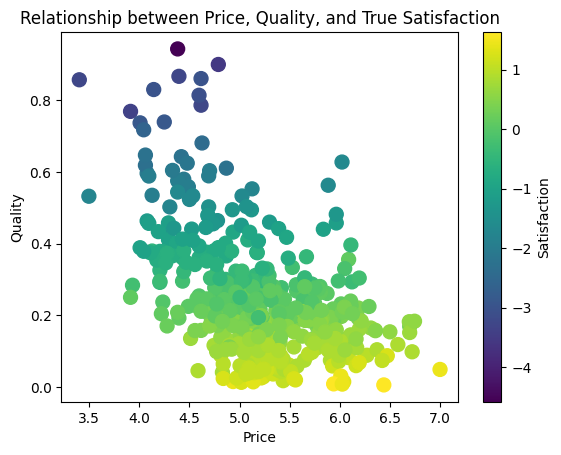

In [29]:
# Test many hidden layer sizes for predicting satisfaction, and two few actually led to mode collapse
# [] led to mode collapse
# [2, 2], [4, 4] did too

# Now plot the relationship between quality, true_satisfactions, and price for the test set

# Create a scatter plot
plt.scatter(prices, qualities, c=true_satisfactions, cmap='viridis', s=100)

# Add labels and title
plt.xlabel('Price')
plt.ylabel('Quality')
plt.title('Relationship between Price, Quality, and True Satisfaction')

# Add colorbar for quality
cbar = plt.colorbar()
cbar.set_label('Satisfaction')

# Show the plot
plt.show()

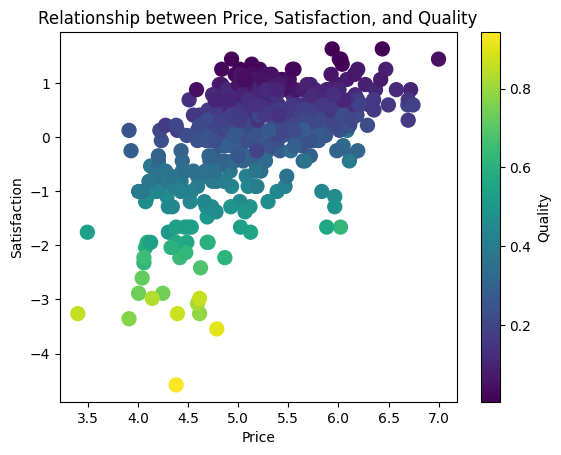

In [30]:
# Create a scatter plot
plt.scatter(prices, true_satisfactions, c=qualities, cmap='viridis', s=100)

# Add labels and title
plt.xlabel('Price')
plt.ylabel('Satisfaction')
plt.title('Relationship between Price, Satisfaction, and Quality')

# Add colorbar for quality
cbar = plt.colorbar()
cbar.set_label('Quality')

# Show the plot
plt.show()

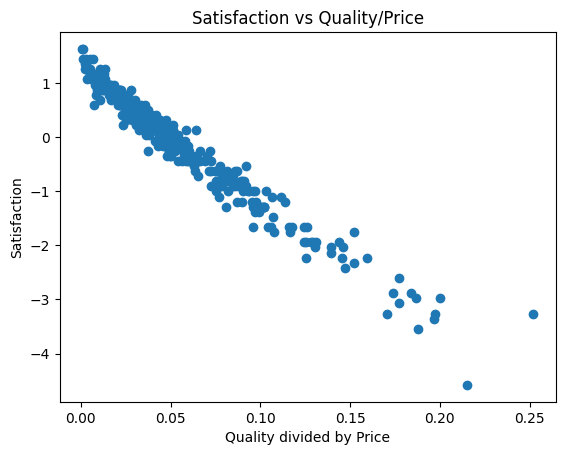

In [31]:
# Consider the relationship between quality/price and satisfaction


quality_divided_by_price = [quality/price for quality,price in zip(qualities,prices)]

plt.scatter(quality_divided_by_price, true_satisfactions)

# Add labels and title
plt.xlabel('Quality divided by Price')
plt.ylabel('Satisfaction')
plt.title('Satisfaction vs Quality/Price')
plt.show()

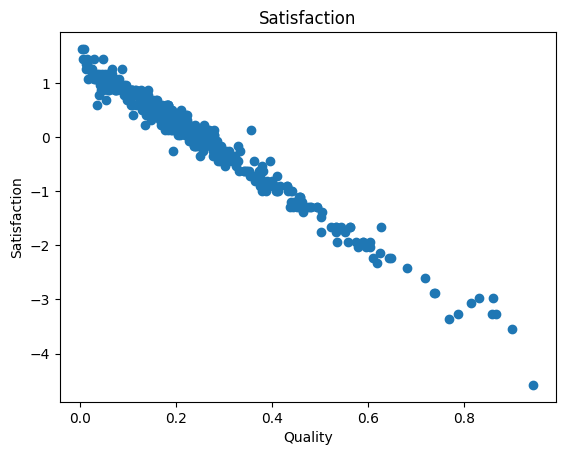

In [32]:
plt.scatter(qualities, true_satisfactions)

# Add labels and title
plt.xlabel('Quality')
plt.ylabel('Satisfaction')
plt.title('Satisfaction')
plt.show()

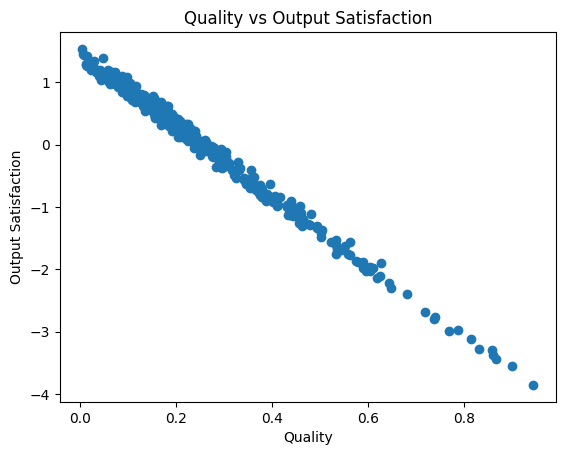

In [33]:
# from torchviz import make_dot

# batch = next(iter(train_loader_just_one_quality))


# _test_batch_idx, (test_X, test_p, test_target_total_s) = enumerate(test_loader_just_one_quality)[0]
# test_total_s, test_total_quality = model_just_one_quality(test_X, test_p)

# make_dot(test_total_s, params=dict(list(model_just_one_quality.named_parameters()))).render("rnn_torchviz", format="png")


plt.scatter(qualities, output_satisfactions)

# Add labels and title
plt.xlabel('Quality')
plt.ylabel('Output Satisfaction')
plt.title('Quality vs Output Satisfaction')
plt.show()

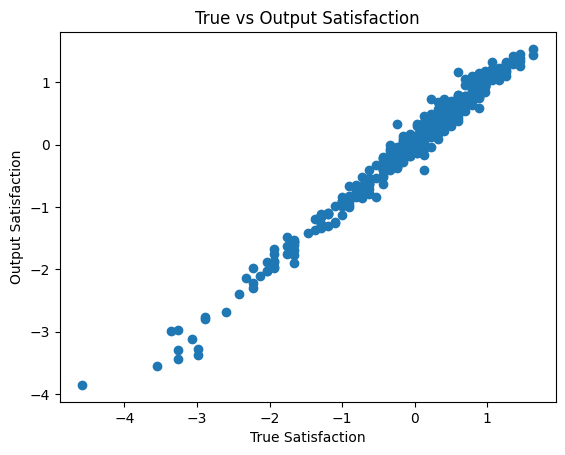

In [34]:
plt.scatter(true_satisfactions, output_satisfactions)

# Add labels and title
plt.xlabel('True Satisfaction')
plt.ylabel('Output Satisfaction')
plt.title('True vs Output Satisfaction')
plt.show()